In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
from torchdrug import datasets
import pandas as pd
from torchdrug import transforms
from pathlib import Path
import matplotlib.pyplot as plt

from itertools import repeat
import collections.abc
from torch import nn

from plaid.esmfold import esmfold_v1
from plaid.compression.hourglass_vq import HourglassVQLightningModule

import torch



truncate_transform = transforms.TruncateProtein(max_length=200, random=False)
protein_view_transform = transforms.ProteinView(view="residue")
transform = transforms.Compose([truncate_transform, protein_view_transform])

dataset = datasets.BetaLactamase("~/protein-datasets/", atom_feature=None, bond_feature=None, residue_feature="default", transform=transform)
train_set, valid_set, test_set = dataset.split()
print("The label of first sample: ", dataset[0][dataset.target_fields[0]])
print("train samples: %d, valid samples: %d, test samples: %d" % (len(train_set), len(valid_set), len(test_set)))

19:24:42   Extracting /homefs/home/lux70/protein-datasets/beta_lactamase.tar.gz to /homefs/home/lux70/protein-datasets


Constructing proteins from sequences: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5198/5198 [00:08<00:00, 625.24it/s]


The label of first sample:  0.9426838159561157
train samples: 4158, valid samples: 520, test samples: 520


In [44]:
print(train_set[0]['graph'])
print(train_set[0]['scaled_effect1'])

Protein(num_atom=0, num_bond=0, num_residue=200)
0.9426838159561157


In [68]:
train_set[0].keys()

dict_keys(['graph', 'scaled_effect1'])

In [45]:
scaled_effects = train_set.dataset.targets['scaled_effect1']
sequences = train_set.dataset.sequences


df = pd.DataFrame({"target": scaled_effects, "sequences": sequences})
df.head()

,target,sequences
0,0.942684,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
1,0.645768,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
2,0.746097,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
3,0.665239,MSIQHFRVALIPFFAAFCLPVFTHPETLVKVKDAEDQLGARVGYIE...
4,1.018830,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...


<Axes: >

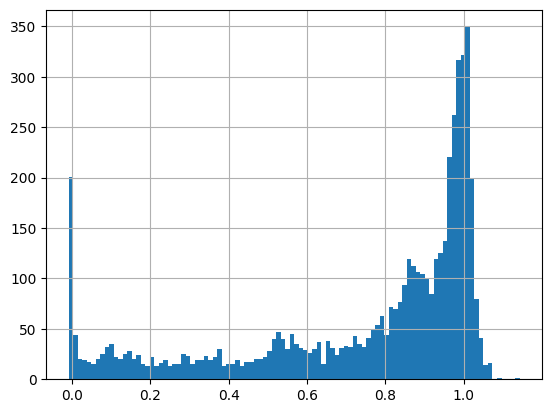

In [46]:
%matplotlib inline
df.target.hist(bins=100)


In [23]:
# dataset = datasets.ProteinNet("~/protein-datasets/", atom_feature=None, bond_feature=None, residue_feature="default", transform=protein_view_transform)
# train_set, valid_set, test_set = dataset.split()
# print("Residue position: ", dataset[0]["graph"].residue_position[:3])
# print("Valid mask: ", dataset[0]["graph"].mask[:3])
# print("train samples: %d, valid samples: %d, test samples: %d" % (len(train_set), len(valid_set), len(test_set)))

18:43:50   Downloading https://miladeepgraphlearningproteindata.s3.us-east-2.amazonaws.com/data/proteinnet.tar.gz to /homefs/home/lux70/protein-datasets/proteinnet.tar.gz
18:44:02   Extracting /homefs/home/lux70/protein-datasets/proteinnet.tar.gz to /homefs/home/lux70/protein-datasets


Constructing proteins from sequences: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25557/25557 [00:33<00:00, 761.77it/s]

Residue position:  tensor([[ 2.0940e+00,  2.0000e-03, -1.2420e+00],
        [ 5.1260e+00, -2.0210e+00, -2.3290e+00],
        [ 7.5230e+00,  6.1500e-01, -3.6610e+00]])
Valid mask:  tensor([True, True, True])
train samples: 25299, valid samples: 224, test samples: 34


In [39]:
dataset

ProteinNet(
  #sample: 25557
  #task: 2
)

In [69]:

# From PyTorch internals
def _ntuple(n):
    def parse(x):
        if isinstance(x, collections.abc.Iterable) and not isinstance(x, str):
            return tuple(x)
        return tuple(repeat(x, n))
    return parse


to_1tuple = _ntuple(1)
to_2tuple = _ntuple(2)
to_3tuple = _ntuple(3)
to_4tuple = _ntuple(4)
to_ntuple = _ntuple

import lightning as L

class Mlp(L.LightningModule): 
    """ MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(
            self,
            in_features,
            hidden_features=None,
            out_features=None,
            act_layer=nn.GELU,
            norm_layer=None,
            bias=True,
            drop=0.,
            use_conv=False,
            lr=1e-4,
            lr_adam_betas=(0.9, 0.999),
            lr_sched_type: str = "constant",
            lr_num_warmup_steps: int = 0,
            lr_num_training_steps: int = 10_000_000,
            lr_num_cycles: int = 1,
            embed_fn = embed_fn
    ):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        bias = to_2tuple(bias)
        drop_probs = to_2tuple(drop)
        linear_layer = partial(nn.Conv2d, kernel_size=1) if use_conv else nn.Linear

        self.fc1 = linear_layer(in_features, hidden_features, bias=bias[0])
        self.act = act_layer()
        self.drop1 = nn.Dropout(drop_probs[0])
        self.norm = norm_layer(hidden_features) if norm_layer is not None else nn.Identity()
        self.fc2 = linear_layer(hidden_features, out_features, bias=bias[1])
        self.drop2 = nn.Dropout(drop_probs[1])

        self.lr = lr
        self.lr_adam_betas = lr_adam_betas
        self.lr_sched_type = lr_sched_type
        self.lr_num_warmup_steps = lr_num_warmup_steps
        self.lr_num_training_steps = lr_num_training_steps
        self.lr_num_cycles = lr_num_cycles


    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.norm(x)
        x = self.fc2(x)
        x = self.drop2(x)

    def configure_optimizers(self):
        parameters = list(self.enc.parameters()) + list(self.dec.parameters())
        if not self.quantizer is None:
            parameters += list(self.quantizer.parameters())

        optimizer = torch.optim.AdamW(
            parameters,
            lr=self.lr,
            betas=self.lr_adam_betas
        )
        scheduler = get_lr_scheduler(
            optimizer=optimizer,
            sched_type=self.lr_sched_type,
            num_warmup_steps=self.lr_num_warmup_steps,
            num_training_steps=self.lr_num_training_steps,
            num_cycles=self.lr_num_cycles,
        )
        scheduler = {"scheduler": scheduler, "interval": "step", "frequency": 1}
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def forward(embedding):
        return self(embedding)

    def run_batch(batch):
        sequences = batch['graph'].sequence
        target = batch['scaled_effect1']
        emb = embed_fn(sequences)
        pred = self(emb)
        import pdb;pdb.set_trace()
        
mlp = Mlp(8, 1024, 1, drop=0.1)

In [30]:
esmfold = esmfold_v1()

ckpt_dir = Path("/data/lux70/plaid/checkpoints/hourglass_vq")
hourglass = HourglassVQLightningModule.load_from_checkpoint(ckpt_dir / compression_model_id / "last.ckpt")

using quantizer tanh


NameError: name 'batch' is not defined

In [33]:
device = torch.device("cuda")
hourglass = hourglass.to(device).eval().requires_grad_(False)
esmfold = esmfold.to(device).eval().requires_grad_(False)
mlp = mlp.to(device)

In [54]:
def embed_fn(esmfold, scaler, hourglass, sequences):
    output = esmfold.infer_embedding(sequences)
    x, mask = output['s'], output['mask']
    device = esmfold.device
    x, mask = x.to(device), mask.to(device).bool()
    x = scaler.scale(x)
    x = hourglass(x, mask, infer_only=True)
    return torch.from_numpy(x).to(device)

In [57]:
from plaid.utils import LatentScaler

scaler = LatentScaler()
output = embed_fn(esmfold, scaler, hourglass, df.sequences.values[:10])

In [59]:
output.shape

torch.Size([10, 143, 64])

<Axes: >

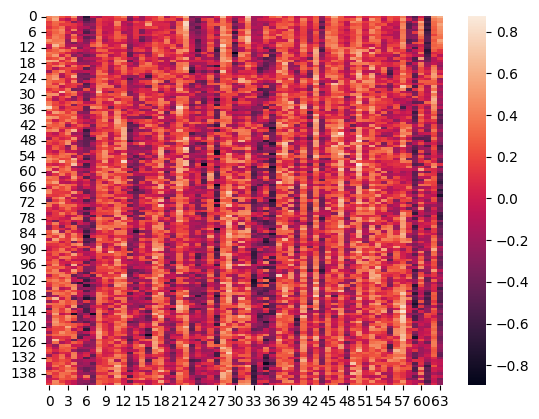

In [63]:
import seaborn as sns
sns.heatmap(output[0].detach().cpu().numpy())

<Axes: >

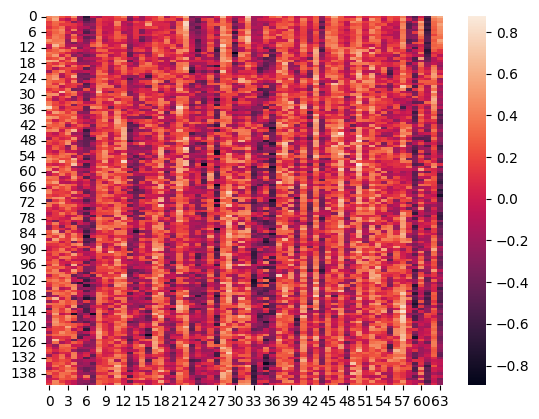

In [64]:
import seaborn as sns
sns.heatmap(output[1].detach().cpu().numpy())